In [1]:
#importing libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
# Fetch data from Yahoo Finance
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Close'].values.reshape(-1, 1)

# Prepare the dataset
def prepare_dataset(data, look_back=50):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

# Parameters
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-01-01'
look_back = 50

# Fetch and scale data
raw_data = fetch_stock_data(ticker, start_date, end_date)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)

# Prepare datasets
X, Y = prepare_dataset(scaled_data, look_back)
X = X.reshape(X.shape[0], X.shape[1], 1)  # LSTM input shape [batch_size, seq_len, input_dim]

[*********************100%%**********************]  1 of 1 completed


In [3]:
class StockPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob=0.2):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_dim).to(device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_dim).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])  # Apply dropout to the output of the last LSTM layer
        out = self.fc(out)
        return out

# Parameters
input_dim = 1
hidden_dim = 50
num_layers = 2
output_dim = 1
dropout_prob = 0.2  # Set dropout probability

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StockPredictor(input_dim, hidden_dim, num_layers, output_dim, dropout_prob).to(device)


In [4]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X, dtype=torch.float32).to(device)
Y_train = torch.tensor(Y, dtype=torch.float32).to(device)

# Create DataLoader
dataset = TensorDataset(X_train, Y_train)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
num_epochs = 50
model.train()
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device).view(-1, 1)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/50], Loss: 0.0174
Epoch [20/50], Loss: 0.0549
Epoch [30/50], Loss: 0.0139
Epoch [40/50], Loss: 0.0037
Epoch [50/50], Loss: 0.0078


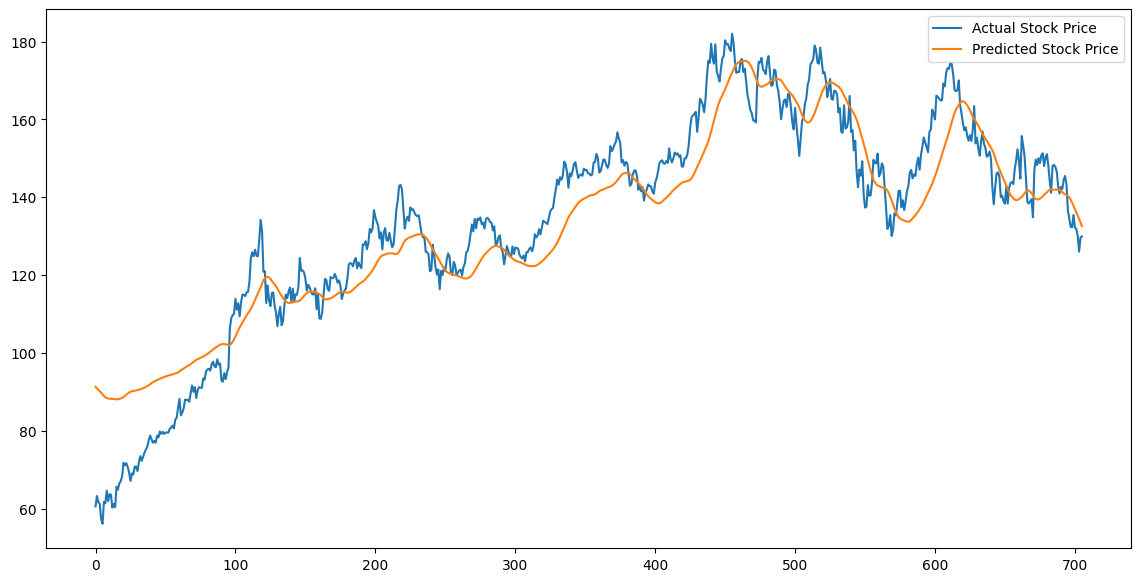

In [5]:
# Make predictions
model.eval()
with torch.no_grad():
    predicted = model(X_train).cpu().numpy()

# Inverse transform to original scale
predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(Y_train.cpu().numpy().reshape(-1, 1))

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(actual, label='Actual Stock Price')
plt.plot(predicted, label='Predicted Stock Price')
plt.legend()
plt.show()
